In [2]:
!pip install split-folders

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from pathlib import Path
import random
from PIL import Image
import shutil
import splitfolders

import xml.etree.ElementTree as ET

## Display Sample Image and annotation

In [4]:
img_name = '/kaggle/input/face-mask-detection/images/maksssksksss0.png'
img_annot = '/kaggle/input/face-mask-detection/annotations/maksssksksss0.xml'

In [5]:
with open(img_annot) as annot_file:
    print(''.join(annot_file.readlines()))


<annotation>
    <folder>images</folder>
    <filename>maksssksksss0.png</filename>
    <size>
        <width>512</width>
        <height>366</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>without_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>79</xmin>
            <ymin>105</ymin>
            <xmax>109</xmax>
            <ymax>142</ymax>
        </bndbox>
    </object>
    <object>
        <name>with_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>185</xmin>
            <ymin>100</ymin>
            <xmax>226</xmax>
            <ymax>144</ymax>
        </bndbox>
    </object>
    <object>
        <name>without_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</

In [6]:
tree = ET.parse(img_annot)
root = tree.getroot()
sample_bb = []
for neighbor in root.iter('bndbox'):
    xmin = int(neighbor.find('xmin').text)
    ymin = int(neighbor.find('ymin').text)
    xmax = int(neighbor.find('xmax').text)
    ymax = int(neighbor.find('ymax').text)
    
    sample_bb.append([xmin, ymin, xmax, ymax])
print(sample_bb)

[[79, 105, 109, 142], [185, 100, 226, 144], [325, 90, 360, 141]]


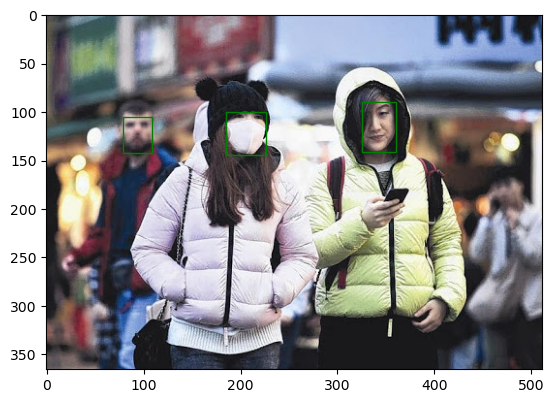

In [7]:
sample_img = cv2.imread(img_name)
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots()
ax.imshow(sample_img)
for xmin, ymin, xmax, ymax in sample_bb:
    rect = patches.Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), 
                             linewidth=1, edgecolor='g', facecolor='none')
    ax.add_patch(rect)
plt.show()

## Extract Annotations

In [8]:
data_dict = {
    'filename': [],
    'label': [],
    'width': [],
    'height': [],
    'depth': [],
    'bndbox': []
}

# sample bndbox dataframe
tree = ET.parse(img_annot)
root = tree.getroot()
filename = root.find('filename').text
filename = filename[0:-4]

for obj in root.findall('object'):
    bndbox_label = obj.find('name').text
    
    bndbox = []
    bndbox_tree = obj.find('bndbox')
    bndbox.append(int(bndbox_tree.find('xmin').text))
    bndbox.append(int(bndbox_tree.find('ymin').text))
    bndbox.append(int(bndbox_tree.find('xmax').text))
    bndbox.append(int(bndbox_tree.find('ymax').text))
    
    size = root.find('size')
    data_dict['filename'].append(filename)
    data_dict['width'].append(int(size.find('width').text))
    data_dict['height'].append(int(size.find('height').text))
    data_dict['depth'].append(int(size.find('depth').text))
    data_dict['label'].append(bndbox_label)
    data_dict['bndbox'].append(bndbox)

df_bndbox = pd.DataFrame(data_dict)
df_bndbox.head()

,filename,label,width,height,depth,bndbox
0,maksssksksss0,without_mask,512,366,3,"[79, 105, 109, 142]"
1,maksssksksss0,with_mask,512,366,3,"[185, 100, 226, 144]"
2,maksssksksss0,without_mask,512,366,3,"[325, 90, 360, 141]"


## Data pre-processing

In [9]:
image_dir = '/kaggle/input/face-mask-detection/images'
annotation_dir = '/kaggle/input/face-mask-detection/annotations'

print(f'Total numbers of annotations : {len(os.listdir(annotation_dir))}')
print(f'Total numbers of imaages : {len(os.listdir(image_dir))}')

Total numbers of annotations : 853
Total numbers of imaages : 853


#### Parse Annotations

In [10]:
annotation_files = list(Path(annotation_dir).glob(r'**/*{}'.format('xml')))
img_bndbox_dict = {
    'filename': [],
    'label': [],
    'width': [],
    'height': [],
    'depth': [],
    'bndbox': []
}
for annotation_filepath in annotation_files:
    tree = ET.parse(annotation_filepath)
    root = tree.getroot()
    filename = root.find('filename').text
    size_tree = root.find('size')
    
    filename = filename[0:-4]
    img_width = int(size_tree.find('width').text)
    img_height = int(size_tree.find('height').text)
    img_depth = int(size_tree.find('depth').text)
    
    for obj in root.findall('object'):
        bndbox_label = obj.find('name').text
        bndbox_coord = []
        bndbox_tree = obj.find('bndbox')
        bndbox_coord.append(int(bndbox_tree.find('xmin').text))
        bndbox_coord.append(int(bndbox_tree.find('ymin').text))
        bndbox_coord.append(int(bndbox_tree.find('xmax').text))
        bndbox_coord.append(int(bndbox_tree.find('ymax').text))
        
        img_bndbox_dict['filename'].append(filename)
        img_bndbox_dict['width'].append(img_width)
        img_bndbox_dict['height'].append(img_height)
        img_bndbox_dict['depth'].append(img_depth)
        img_bndbox_dict['label'].append(bndbox_label)
        img_bndbox_dict['bndbox'].append(bndbox_coord)

In [11]:
data_df = pd.DataFrame(img_bndbox_dict)

In [12]:
data_df.shape

(4072, 6)

In [13]:
data_df['label'].value_counts()

with_mask                3232
without_mask              717
mask_weared_incorrect     123
Name: label, dtype: int64

#### Display random images with bounding boxes

In [14]:
random_imgs = random.sample(os.listdir(image_dir), 6)
random_imgs

['maksssksksss815.png',
 'maksssksksss437.png',
 'maksssksksss827.png',
 'maksssksksss754.png',
 'maksssksksss580.png',
 'maksssksksss669.png']

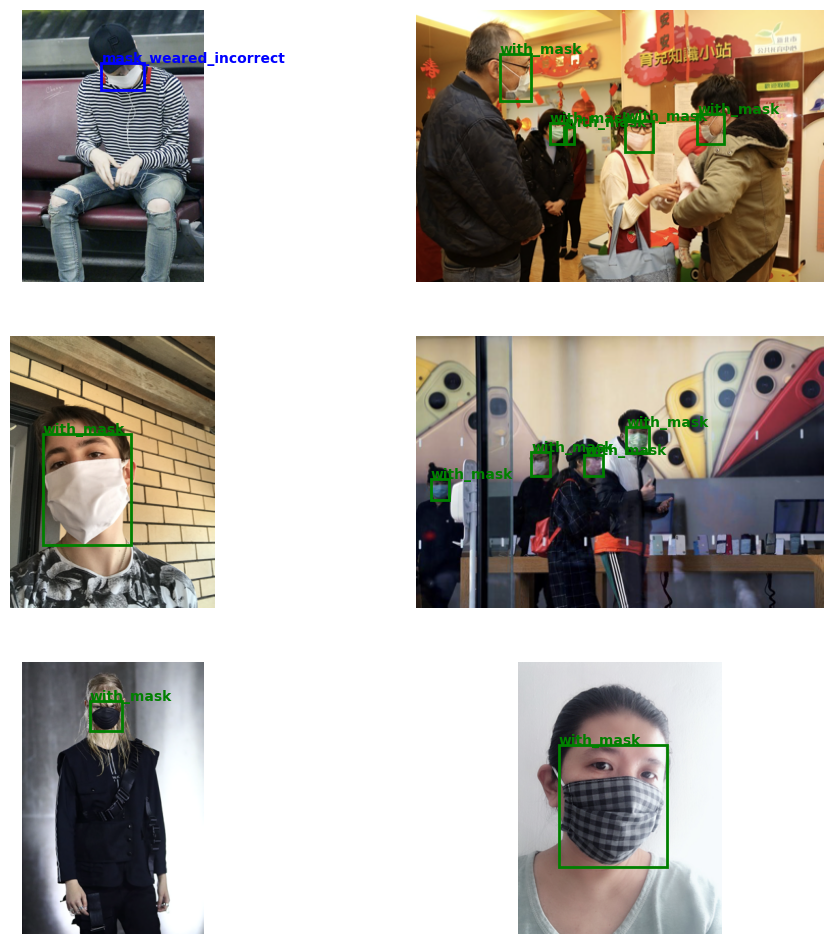

In [15]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
ax = ax.ravel()
for i, imgname in enumerate(random_imgs):
    current_img_df = data_df[data_df['filename'] == imgname[0:-4]]
    image = cv2.imread(f'{image_dir}/{imgname}')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # OpenCV uses BGR, matplotlib uses RGB => need to convert
    ax[i].imshow(image)
    ax[i].axis(False)
#     ax.flat[i].imshow(image)
#     ax.flat[i].axis(False)
    
    bndboxes = []
    for df_idx in range(0, len(current_img_df)):
        edgecolor = 'g'
        img_label = current_img_df.iloc[df_idx]['label']
        if img_label == 'without_mask':
            edgecolor = 'r'
        if img_label == 'mask_weared_incorrect':
            edgecolor = 'b'
        xmin, ymin, xmax, ymax = current_img_df.iloc[df_idx]['bndbox']
        # Draw Bounding box over image
        rectangle = patches.Rectangle([xmin, ymin], xmax-xmin, ymax-ymin,
                                     linewidth=2, edgecolor=edgecolor, facecolor='none')
#         # Add text to bounding box
        rx, ry = rectangle.get_xy()
        ax[i].annotate(img_label, (rx, ry), color=edgecolor, weight='bold', fontsize=10, ha='left', va='baseline')
        ax[i].add_patch(rectangle)
#         ax.flat[i].annotate(img_label, (rx, ry), color=edgecolor, weight='bold', fontsize=10, ha='left', va='baseline')
#         ax.flat[i].add_patch(rectangle)

### Sample Crop Image

In [16]:
# Test crop image
sample_img_name = data_df.sample(1, random_state=42)
sample_img_name['filename'].values[0]

'maksssksksss476'

In [17]:
sample_df = data_df[data_df['filename'] == sample_img_name['filename'].values[0]]
sample_df

,filename,label,width,height,depth,bndbox
599,maksssksksss476,with_mask,400,267,3,"[353, 17, 381, 51]"
600,maksssksksss476,with_mask,400,267,3,"[210, 40, 238, 68]"
601,maksssksksss476,with_mask,400,267,3,"[17, 72, 41, 97]"
602,maksssksksss476,with_mask,400,267,3,"[105, 61, 129, 86]"
603,maksssksksss476,with_mask,400,267,3,"[94, 116, 118, 152]"
604,maksssksksss476,without_mask,400,267,3,"[286, 52, 309, 76]"
605,maksssksksss476,without_mask,400,267,3,"[116, 110, 143, 138]"


In [18]:
img_path = '/kaggle/input/face-mask-detection/images/' + sample_img_name['filename'].values[0] + '.png'
img_path

'/kaggle/input/face-mask-detection/images/maksssksksss476.png'

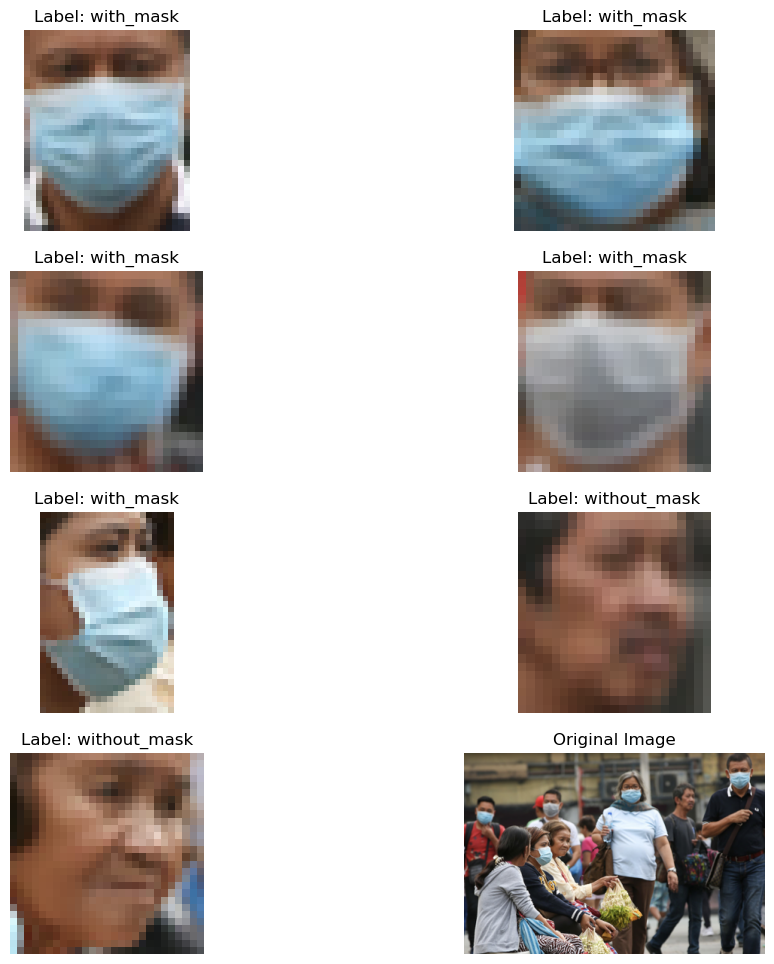

In [19]:
ex_img = cv2.imread(img_path)
ex_img = cv2.cvtColor(ex_img, cv2.COLOR_BGR2RGB)
no_records = len(sample_df)
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(12, 12))
ax = ax.ravel()
for idx in range(0, no_records):
    xmin, ymin, xmax, ymax = sample_df.iloc[idx]['bndbox']
    cropped_img = ex_img[ymin:ymax, xmin:xmax]
    label = sample_df.iloc[idx]['label']
    ax[idx].imshow(cropped_img)
    ax[idx].title.set_text(f'Label: {label}')
    ax[idx].axis(False)

ax[7].imshow(ex_img)
ax[7].axis(False)
ax[7].title.set_text('Original Image')

### Create Cropped Image dataset

In [20]:
data_df.columns

Index(['filename', 'label', 'width', 'height', 'depth', 'bndbox'], dtype='object')

In [21]:
with_mask_dir = '/kaggle/working/dataset/with_mask'
without_mask_dir = '/kaggle/working/dataset/without_mask'
mask_weared_incorrect_dir = '/kaggle/working/dataset/mask_weared_incorrect'

In [22]:
# Create outputfolder
os.mkdir('/kaggle/working/dataset')
os.mkdir(with_mask_dir)
os.mkdir(without_mask_dir)
os.mkdir(mask_weared_incorrect_dir)

In [23]:
for filename in data_df['filename'].unique():
    current_file = filename
    image = cv2.imread(f'/kaggle/input/face-mask-detection/images/{filename}.png')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    current_image_df = data_df[data_df['filename'] == current_file]
    # Get all Bounding boxes coordinate
    for idx in range(0, len(current_image_df)):
        # Cropped image according to Bounding box coordinate
        xmin, ymin, xmax, ymax = current_image_df.iloc[idx]['bndbox']
        cropped_img_label = current_image_df.iloc[idx]['label']
        cropped_img = image[ymin:ymax, xmin:xmax]
        cropped_img = cv2.resize(cropped_img, (32, 32))
        if cropped_img_label == 'with_mask':
            cv2.imwrite(f'{with_mask_dir}/{current_file}_{idx}_{cropped_img_label}.png', cropped_img)
        elif cropped_img_label == 'without_mask':
            cv2.imwrite(f'{without_mask_dir}/{current_file}_{idx}_{cropped_img_label}.png', cropped_img)
        else:
            cv2.imwrite(f'{mask_weared_incorrect_dir}/{current_file}_{idx}_{cropped_img_label}.png', cropped_img)

In [24]:
len(os.listdir('/kaggle/working/dataset/with_mask'))

3232

## Split training, validation, test set

In [25]:
dataset_path = '/kaggle/working/dataset'
dataset_path = Path(dataset_path)

In [26]:
# split dataset using splitfolders
splitfolders.ratio(dataset_path, output='imgs', seed=42, ratio=(.56, .24, .20), group_prefix=None) # train-test 80:20 , train-val 70:30

Copying files: 4072 files [00:00, 5315.17 files/s]


## Image preprocessing

In [27]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

In [28]:
os.listdir('/kaggle/working/imgs/train')

['with_mask', 'mask_weared_incorrect', 'without_mask']

In [29]:
img_height, img_width = 32, 32
input_shape = (img_height, img_width, 3)

In [30]:
datagen = ImageDataGenerator(rescale=1./255, 
                             horizontal_flip=True, 
                             vertical_flip=True, 
                             width_shift_range=0.2, 
                             height_shift_range=0.2, 
                             zoom_range=0.3,
                             brightness_range=[0.2,1.2])

In [31]:
train_ds = datagen.flow_from_directory('imgs/train',
                                      target_size=(img_height, img_width),
                                      subset='training',
                                      class_mode='categorical')
val_ds = datagen.flow_from_directory('imgs/val',
                                      target_size=(img_height, img_width),
                                      class_mode='categorical', 
                                      shuffle=False)
test_ds = datagen.flow_from_directory('imgs/test',
                                      target_size=(img_height, img_width),
                                      class_mode='categorical',
                                      shuffle=False)

Found 2278 images belonging to 3 classes.
Found 976 images belonging to 3 classes.
Found 818 images belonging to 3 classes.


In [32]:
# class distribution in each dataset
class_label = ['with_mask', 'without_mask', 'mask_weared_incorrect']
dataset_name = ['train', 'val', 'test']
class_dist_dict = {
    'dataset': [],
    'with_mask': [],
    'without_mask': [],
    'mask_weared_incorrect': []
}
for ds in dataset_name:
    class_dist_dict['dataset'].append(ds)
    current_dir = 'imgs/' + ds
    class_dist_dict['with_mask'].append(len(os.listdir(f'{current_dir}/with_mask')))
    class_dist_dict['without_mask'].append(len(os.listdir(f'{current_dir}/without_mask')))
    class_dist_dict['mask_weared_incorrect'].append(len(os.listdir(f'{current_dir}/mask_weared_incorrect')))

In [33]:
class_dist_df = pd.DataFrame(class_dist_dict)
class_dist_df

,dataset,with_mask,without_mask,mask_weared_incorrect
0,train,1809,401,68
1,val,775,172,29
2,test,648,144,26


In [34]:
# Compute class weights in training dataset
print(f'mask_weared_incorrect[0] class weights : {(2262+501+86)/(3*86):.3f}')
print(f'with_mask[1] class weights : {(2262+501+86)/(3*2262):.3f}')
print(f'without_mask[2] class weights : {(2262+501+86)/(3*501):.3f}')

mask_weared_incorrect[0] class weights : 11.043
with_mask[1] class weights : 0.420
without_mask[2] class weights : 1.896


In [35]:
train_ds.class_indices

{'mask_weared_incorrect': 0, 'with_mask': 1, 'without_mask': 2}

In [36]:
class_weights = {
    0: 11.043, # mask_wearted_incorrect
    1: 0.420, # with_mask
    2: 1.896 # without_mask
}

## Vanilla CNN architecture

In [37]:
def plot_train_history(history):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [38]:
img_height, img_width = 32, 32
input_shape = (img_height, img_width, 3)

In [39]:
model_cnn = Sequential([
    Conv2D(16, 3, activation='relu', padding='same', input_shape=input_shape),
    MaxPooling2D(pool_size=(2, 2), padding='same'),
    Conv2D(32, 3, activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), padding='same'),
    
    Conv2D(64, 3, activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), padding='same'),
    
    Conv2D(128, 3, activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), padding='same'),
    
    Conv2D(256, 3, activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), padding='same'),
    Dropout(0.3),
    
    Flatten(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])

In [40]:
model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 64)         0

In [41]:
# Callbacks
models_dir = 'saved_models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

checkpointer = ModelCheckpoint(filepath='saved_models/model_cnn.hdf5', 
                               monitor='val_accuracy', 
                               mode='max', 
                               verbose=1, 
                               save_best_only=True)
earlystopping = EarlyStopping(monitor='val_loss', verbose=1, patience=8) # mode='min'
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=0.00001)

callbacks = [earlystopping, reduce_lr, checkpointer]

In [42]:
history_cnn = model_cnn.fit(train_ds, epochs=30, shuffle=True, validation_data=val_ds, callbacks=callbacks, class_weight=class_weights)

Epoch 1/30


2023-03-06 15:17:11.923036: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


71/72 [============================>.] - ETA: 0s - loss: 1.1366 - accuracy: 0.5948
Epoch 1: val_accuracy improved from -inf to 0.23156, saving model to saved_models/model_cnn.hdf5
72/72 [==============================] - 16s 60ms/step - loss: 1.1298 - accuracy: 0.5887 - val_loss: 1.0935 - val_accuracy: 0.2316 - lr: 0.0010
Epoch 2/30
72/72 [==============================] - ETA: 0s - loss: 1.0265 - accuracy: 0.5689
Epoch 2: val_accuracy did not improve from 0.23156
72/72 [==============================] - 5s 62ms/step - loss: 1.0265 - accuracy: 0.5689 - val_loss: 1.0735 - val_accuracy: 0.0297 - lr: 0.0010
Epoch 3/30
72/72 [==============================] - ETA: 0s - loss: 0.9524 - accuracy: 0.5865
Epoch 3: val_accuracy improved from 0.23156 to 0.51639, saving model to saved_models/model_cnn.hdf5
72/72 [==============================] - 4s 53ms/step - loss: 0.9524 - accuracy: 0.5865 - val_loss: 1.1940 - val_accuracy: 0.5164 - lr: 0.0010
Epoch 4/30
72/72 [==============================] -

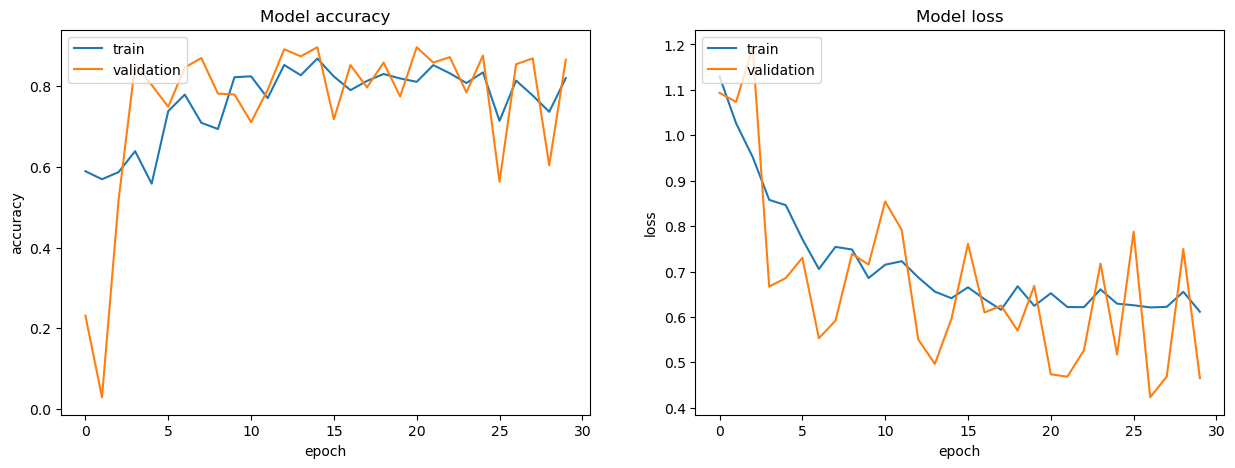

In [43]:
plot_train_history(history_cnn)

In [44]:
y_pred = model_cnn.predict(test_ds)

26/26 [==============================] - 1s 39ms/step


In [45]:
y_pred = np.argmax(y_pred, axis=1)

In [46]:
np.bincount(y_pred) # count occurrences of each class

array([ 46, 597, 175])

In [47]:
clf_report = classification_report(y_pred, test_ds.classes, output_dict=True)
df_clf = pd.DataFrame(clf_report).transpose()
df_clf

,precision,recall,f1-score,support
0,0.269231,0.152174,0.194444,46.000000
1,0.893519,0.969849,0.930120,597.000000
2,0.923611,0.760000,0.833856,175.000000
accuracy,0.878973,0.878973,0.878973,0.878973
macro avg,0.695453,0.627341,0.652807,818.000000
weighted avg,0.864850,0.878973,0.868155,818.000000


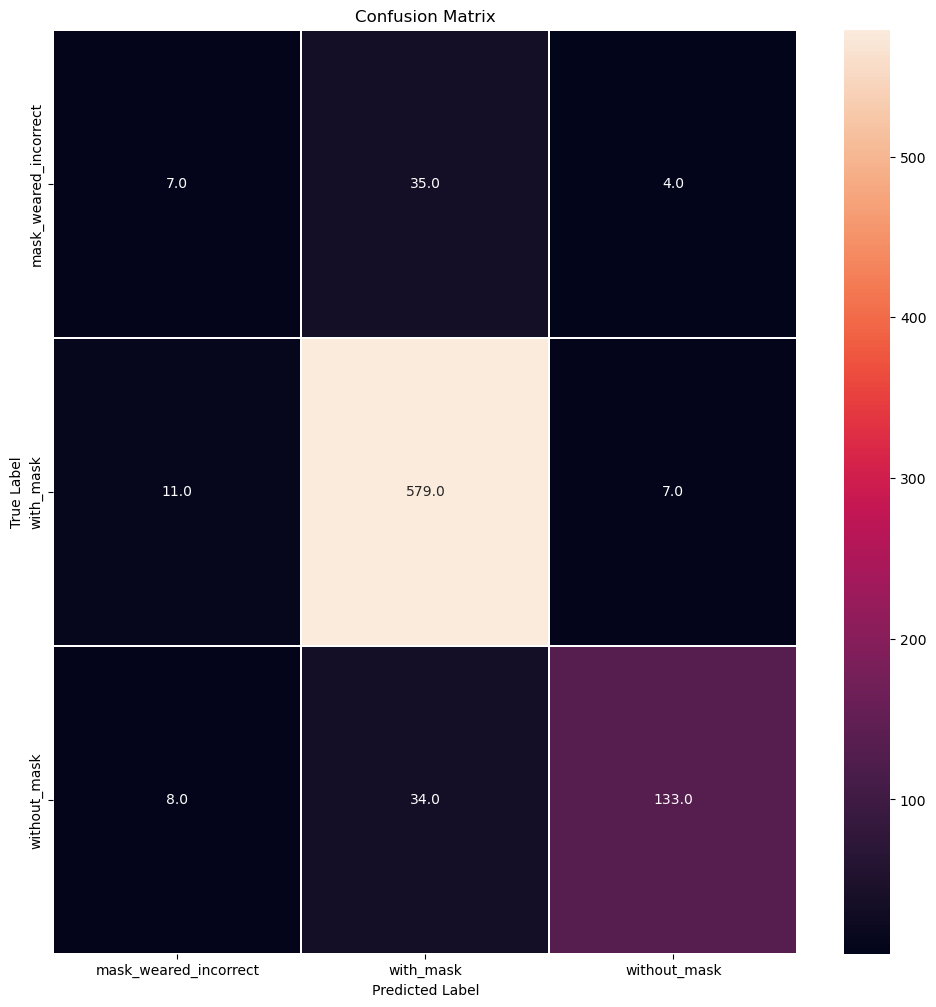

In [48]:
confusion_mtx = confusion_matrix(y_pred, test_ds.classes)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_ds.class_indices)
ax.yaxis.set_ticklabels(test_ds.class_indices)
plt.title("Confusion Matrix")
plt.show()

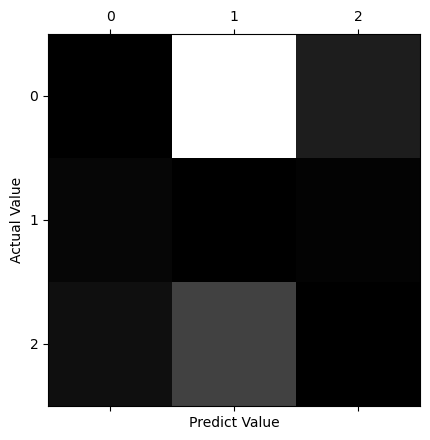

In [49]:
# Confusion matrix normalization
row_sums = confusion_mtx.sum(axis=1, keepdims=True)
norm_confusion_mtx = confusion_mtx / row_sums 
np.fill_diagonal(norm_confusion_mtx, 0)
plt.matshow(norm_confusion_mtx, cmap=plt.cm.gray)
plt.xlabel('Predict Value')
plt.ylabel('Actual Value')
plt.show()

## Haar Cascade

In [50]:
haar_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [51]:
def face_mask_prediction(cropped_img):
    img = cv2.resize(cropped_img, (32, 32))
    img = img.astype(np.float32) / 255.0
    img = tf.expand_dims(img, axis=0)
    predict = model_cnn.predict(img)
    predict = np.argmax(predict)
    return predict

In [52]:
sample_img

array([[[113, 111, 116],
        [110, 108, 113],
        [ 98,  96, 101],
        ...,
        [ 40,  59, 102],
        [ 72,  98, 157],
        [ 86, 116, 186]],

       [[105, 100, 106],
        [ 99,  97, 100],
        [ 88,  86,  89],
        ...,
        [ 39,  58,  98],
        [ 48,  73, 129],
        [ 79, 109, 173]],

       [[ 96,  92,  93],
        [ 91,  87,  88],
        [ 83,  79,  80],
        ...,
        [ 38,  57,  90],
        [ 31,  57, 105],
        [ 71, 100, 157]],

       ...,

       [[ 85,  83,  88],
        [ 87,  85,  90],
        [ 91,  89,  92],
        ...,
        [ 28,  27,  32],
        [ 28,  27,  32],
        [ 29,  28,  33]],

       [[ 86,  84,  89],
        [ 89,  87,  92],
        [ 92,  90,  95],
        ...,
        [ 29,  28,  33],
        [ 29,  28,  33],
        [ 30,  29,  34]],

       [[ 93,  91,  96],
        [ 96,  94,  99],
        [100,  98, 103],
        ...,
        [ 30,  29,  34],
        [ 30,  29,  34],
        [ 31,  30,  35]]

In [53]:
sample_img

array([[[113, 111, 116],
        [110, 108, 113],
        [ 98,  96, 101],
        ...,
        [ 40,  59, 102],
        [ 72,  98, 157],
        [ 86, 116, 186]],

       [[105, 100, 106],
        [ 99,  97, 100],
        [ 88,  86,  89],
        ...,
        [ 39,  58,  98],
        [ 48,  73, 129],
        [ 79, 109, 173]],

       [[ 96,  92,  93],
        [ 91,  87,  88],
        [ 83,  79,  80],
        ...,
        [ 38,  57,  90],
        [ 31,  57, 105],
        [ 71, 100, 157]],

       ...,

       [[ 85,  83,  88],
        [ 87,  85,  90],
        [ 91,  89,  92],
        ...,
        [ 28,  27,  32],
        [ 28,  27,  32],
        [ 29,  28,  33]],

       [[ 86,  84,  89],
        [ 89,  87,  92],
        [ 92,  90,  95],
        ...,
        [ 29,  28,  33],
        [ 29,  28,  33],
        [ 30,  29,  34]],

       [[ 93,  91,  96],
        [ 96,  94,  99],
        [100,  98, 103],
        ...,
        [ 30,  29,  34],
        [ 30,  29,  34],
        [ 31,  30,  35]]

1/1 [==============================] - 0s 20ms/step


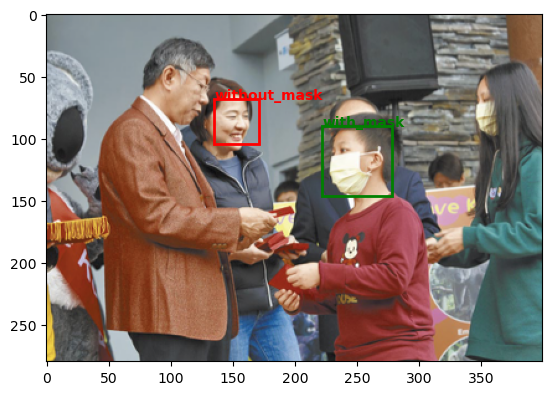

In [54]:
random_filename = random.choice(os.listdir('/kaggle/input/face-mask-detection/images'))
sample_img = f'/kaggle/input/face-mask-detection/images/{random_filename}'

fig, ax = plt.subplots()
img = cv2.imread(sample_img)

faces = haar_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=6)
for (x,y,w,h) in faces:
    xmin, ymin, w, h = x, y, w, h
    cropped_img = img[ymin:ymin+w, xmin:xmin+h]
    prediction = face_mask_prediction(cropped_img)
    edgecolor = 'r'
    img_label = 'without_mask'
    if prediction == 0:
        edgecolor = 'b'
        img_label = 'mask_weared_incorrect'
    if prediction == 1:
        edgecolor = 'g'
        img_label = 'with_mask'
    rectangle = patches.Rectangle([xmin, ymin], w, h, linewidth=2, edgecolor=edgecolor, facecolor='none')
    rx, ry = rectangle.get_xy()
    ax.annotate(img_label, (rx, ry), color=edgecolor, weight='bold', fontsize=10, ha='left', va='baseline')
    ax.add_patch(rectangle)
ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [55]:
!zip -r file.zip /kaggle/working/saved_models

  adding: kaggle/working/saved_models/ (stored 0%)
  adding: kaggle/working/saved_models/model_cnn.hdf5 (deflated 14%)


In [56]:
!zip -r file2.zip /kaggle/input/face-mask-detection/images/maksssksksss431.png

  adding: kaggle/input/face-mask-detection/images/maksssksksss431.png (deflated 0%)
